In [1]:
from pathlib import Path
import torch
import taichi as ti
from tqdm import trange

from torchvtk.datasets import TorchDataset
from torchvtk.utils import make_4d

from differender.utils import get_tf, in_circles, get_rand_pos
from differender.volume_raycaster import Raycaster, Mode

[Taichi] version 0.8.5, llvm 10.0.0, commit 45c6ad48, linux, python 3.7.11
[I 01/24/22 13:24:00.950 1122] [shell.py:_shell_pop_print@34] Graphical python shell detected, using wrapped sys.stdout
[TaiGLSL] version 0.0.11


In [2]:
import matplotlib.pyplot as plt
def show_im(im):
    fig, axs = plt.subplots(2,3, figsize=(15,10))
    axs[0,0].imshow(im.squeeze()[:3].permute(1,2,0).cpu().numpy())
    axs[0,0].set_title('Color')
    axs[0,1].imshow(im.squeeze()[[3,3,3]].permute(1,2,0).cpu().numpy())
    axs[0,1].set_title('Alpha')
    axs[0,2].imshow(im.squeeze()[[4,4,4]].permute(1,2,0).cpu().numpy())
    axs[0,2].set_title('First Hit')
    axs[1,0].imshow(im.squeeze()[[5,5,5]].permute(1,2,0).cpu().numpy())
    axs[1,0].set_title('Max Opacity')
    axs[1,1].imshow(im.squeeze()[[6,6,6]].permute(1,2,0).cpu().numpy())
    axs[1,1].set_title('Max Gradient')
    axs[1,2].imshow(im.squeeze()[[7,7,7]].permute(1,2,0).cpu().numpy())
    axs[1,2].set_title('WYSIWYP')


In [3]:
N_ITEMS = 50000
W, H = 512, 512
TF_RES = 256
SR = 16.0 # Sampling rate

out_dir = Path('/mnt/hdd/dome/STDepth_data')
ds = TorchDataset('/mnt/hdd/shared_datasets/torchvtk/CQ500')
N_VOLUMES = len(ds)
METHOD = Mode.FirstHitDepth
# MEHTOD = Mode.MaxGradient
# METHOD = Mode.MaxOpacity

In [4]:
raycaster = None
for v in trange(N_VOLUMES):
    item = ds[v]
    vol = make_4d(item['vol']).float().to('cuda')
    nam = item['name']
    ti.reset()
    del raycaster
    raycaster = Raycaster(vol.shape[-3:], (W, H), TF_RES, 
        sampling_rate=SR, near=0.1, far=5.0, max_samples=1, mode=METHOD, ti_kwargs={'device_memory_fraction':0.7})
    for i in trange(N_ITEMS // N_VOLUMES):
        lf = get_rand_pos(1).float().to('cuda')
        tf = get_tf('generate', TF_RES).float().to('cuda')
        rgbad = raycaster.raycast_nondiff(vol, tf, lf, sampling_rate=SR).squeeze(0)
        torch.save({
            'vol': nam,
            'tf': tf.squeeze(0).cpu().float(),
            'look_from': lf.squeeze(0).cpu().float(),
            'rgba': rgbad[:4].cpu().half(),
            'first_hit': rgbad[[4]].cpu().half(),
            'max_opacity': rgbad[[5]].cpu().half(),
            'max_gradient': rgbad[[6]].cpu().half(),
            'wysiwyp': rgbad[[7]].cpu().half()
        }, out_dir/f'{nam}_{i}.pt')


  0%|          | 0/395 [00:00<?, ?it/s]

[Taichi] Starting on arch=cuda



  0%|          | 1/395 [00:35<3:56:05, 35.95s/it]

[Taichi] Starting on arch=cuda



  1%|          | 2/395 [01:07<3:37:02, 33.14s/it]

[Taichi] Starting on arch=cuda



  1%|          | 2/395 [01:07<3:42:24, 33.96s/it]


RuntimeError: CUDA out of memory. Tried to allocate 340.00 MiB (GPU 0; 10.76 GiB total capacity; 686.00 MiB already allocated; 176.44 MiB free; 920.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

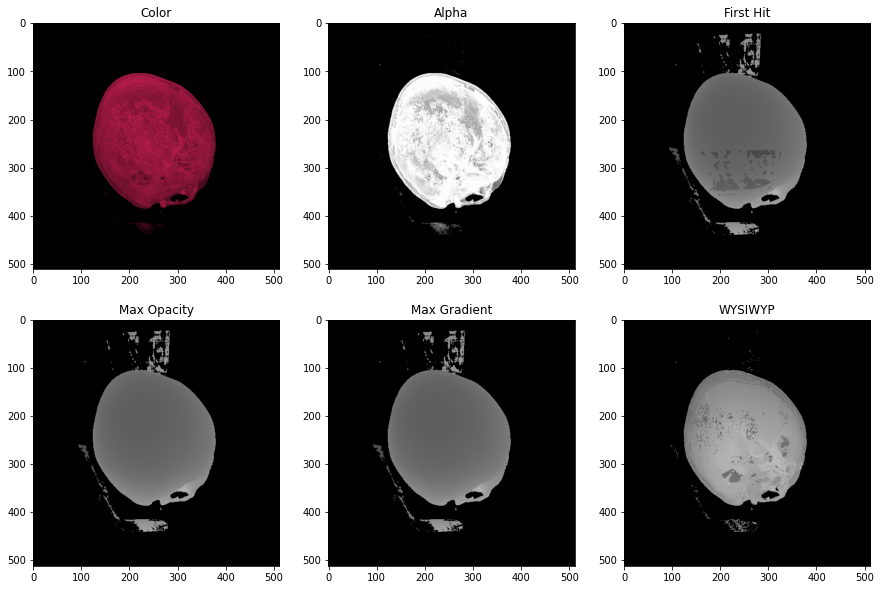

In [5]:
show_im(rgbad)

In [9]:
from itertools import chain

In [17]:
def remainder2pad(s):
    p = (4 - (s % 4)) % 4
    print(p)
    if p < 2:
        return (p, 0)
    if p == 2:
        return (1, 1)
    else:
        return (2, 1)

In [18]:
tuple(map(remainder2pad, tuple(vol.shape[-3:])))

3
0
0


((2, 1), (0, 0), (0, 0))

In [19]:
tuple(reversed(tuple(chain(*map(remainder2pad, tuple(vol.shape[-3:]))))))

3
0
0


(0, 0, 0, 0, 1, 2)

In [12]:
tuple(reversed(tuple(chain(*zip(map(lambda d: (4 - (d % 4)) % 4, tuple(vol.shape[-3:])),(0,0,0))))))

(0, 0, 0, 0, 0, 3)

In [12]:
torch.nn.functional.pad(vol, )

In [5]:
rgbad.shape

torch.Size([1, 8, 512, 512])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


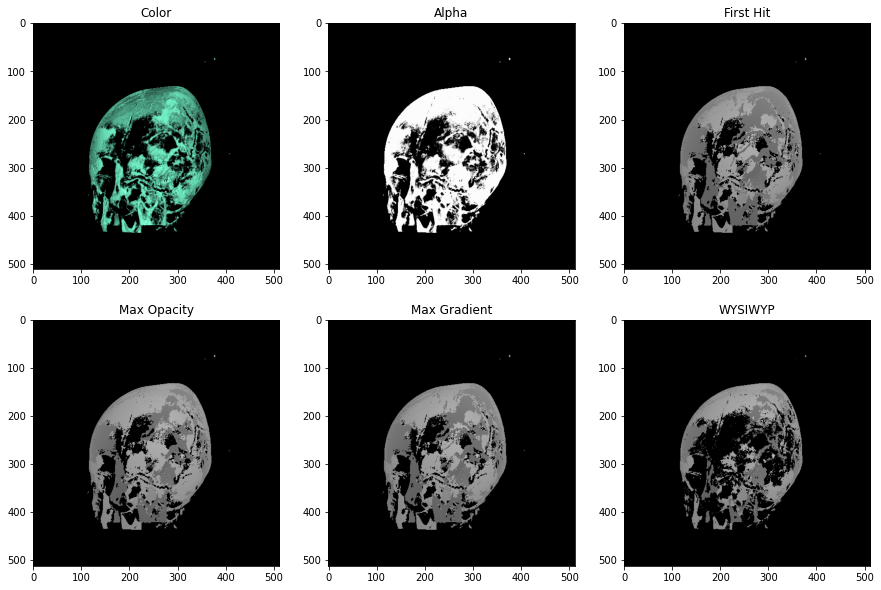

In [7]:
show_im(rgbad)

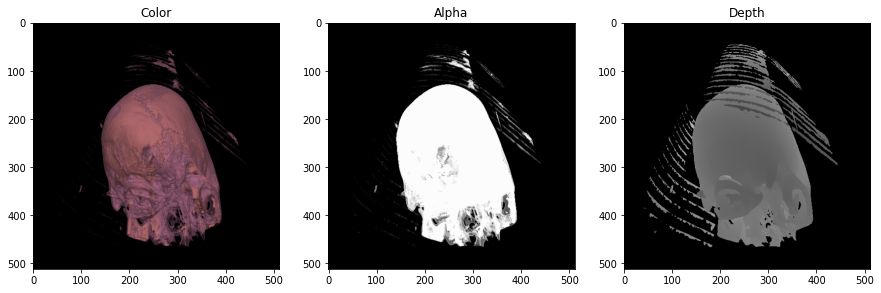

In [25]:
show_im(raycaster.raycast_nondiff(vol, tf, lf, sampling_rate=SR, mode=Mode.FirstHitDepth))

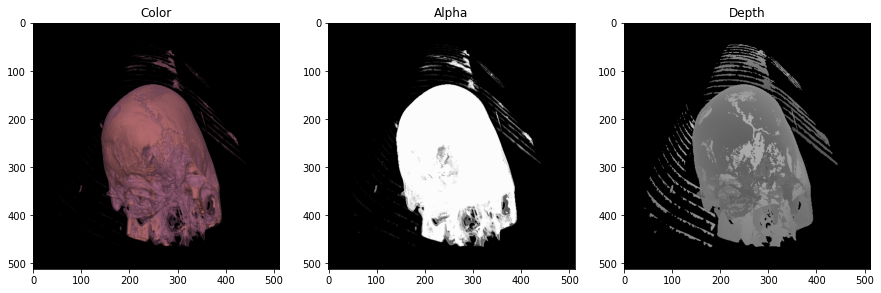

In [26]:
show_im(raycaster.raycast_nondiff(vol, tf, lf, sampling_rate=SR, mode=Mode.MaxOpacity))

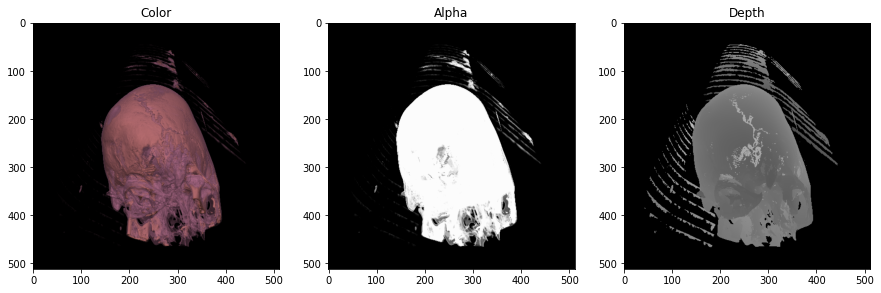

In [27]:
show_im(raycaster.raycast_nondiff(vol, tf, lf, sampling_rate=SR, mode=Mode.MaxGradient))

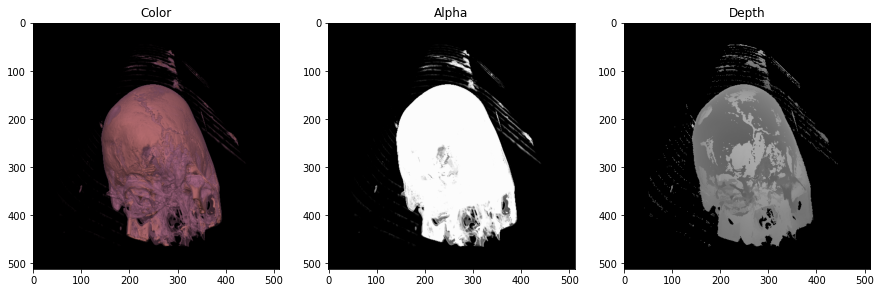

In [28]:
show_im(raycaster.raycast_nondiff(vol, tf, lf, sampling_rate=SR, mode=Mode.WYSIWYP))

In [7]:
rgbad.squeeze()[4].max()

tensor(0., device='cuda:0')

In [10]:
rgbad[0, 3].max()

tensor(0.9905, device='cuda:0')